# ALL RNA separate analysis for leukemic cells
* Deterministic velocity model
* Gene length normalization for unspliced counts
* Compare results with
  * Gene selection from ALL vs proB & proB vs preB scDD results **VS** variable gene selection
  * Filter genes with normalized spliced count max < 2 **VS** no filtering
  * Filter cells by removing 1st and 4th quartile of cells by spliced count **VS** all cells

# 0. Loading the libraries

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

import anndata as ad
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import scvelo as scv
import re
import seaborn as sns

/work/juha/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [4]:
sc.logging.print_versions()

scanpy==1.4.5.dev130+g0612475 anndata==0.6.22.post1+1.g8dcc3cd umap==0.3.9 numpy==1.18.1 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1


In [43]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=60, dpi_save=160, vector_friendly=True)

In [44]:
scv.settings.set_figure_params('scvelo', dpi=60, figsize=(8,5), fontsize=9)

In [7]:
interesting_genes = ['EBF1', 'TCF3', 'ETV6', 'FOXO1', 'TCF4', 'TCFL5', 'LEF1', 'ELK3', 'RUNX1', 'RUNX3', 'LMO2', 'GATA1', 'GATA2', 'CD34', 'PAX5', 'SPI1', 'NFE2', 'SPIB', 'GATA3', 'TXK', 'EOMES', 'HOXA9', 'ERG', 'DNTT', 'IGLL1', 'IGLL5', 'VPREB1', 'SOX4', 'NSMCE1', 'TCL1A', 'MS4A1', 'MME', 'GNG11', 'CCDC69', 'PTPRCAP', 'IRF4', 'AFF3', 'BACH2', 'IKZF2', 'TOP2A', 'PCNA']
s_genes = pd.read_csv('/research/groups/allseq/data/scRNAseq/results/juha_wrk/resources/regev_lab_cell_cycle_genes_S_phase.txt', header=None)[0]
g2m_genes = pd.read_csv('/research/groups/allseq/data/scRNAseq/results/juha_wrk/resources/regev_lab_cell_cycle_genes_G2M_phase.txt', header=None)[0]
diff_genes_xlsx = '/research/groups/allseq/data/scRNAseq/results/juha_wrk/resources/TableS2.xlsx'

In [8]:
# Some parameters
velocity_loom = '/research/groups/allseq/data/scRNAseq/results/juha_wrk/velocity/ALL_velocyto.loom'
ALL_adata_file = '/research/groups/allseq/data/scRNAseq/results/juha_wrk/ALL_scanpy/new_2019_ver5/subset/ALL_subset.h5ad'

<a id="Reading"></a>

# 1. Reading in the data


In [ ]:
# Initialize ALL data for velocity analysis
temp = sc.read(ALL_adata_file)
adata = ad.AnnData(X=np.around(np.expm1(temp.raw.X)), var=temp.raw.var, obs=temp.obs, obsm=temp.obsm, uns=temp.uns)
del temp

In [ ]:
# Load velocyto data
adata_loom = scv.read(velocity_loom, cache=True)

In [ ]:
# Cell ids are a bit different coming from velocyto, modify ids to match them
new_cellids_adata = adata.obs['batch'].str.cat(pd.Series([re.sub('-1_.*$', '', x) for x in adata.obs_names]), sep='_').tolist()
new_cellids_loom = [re.sub(':', '_', x) for x in adata_loom.obs_names]
new_cellids_loom = [re.sub('x$', '', x) for x in new_cellids_loom]

adata.obs['index'] = new_cellids_adata
adata.obs = adata.obs.set_index('index')
adata_loom.obs['index'] = new_cellids_loom
adata_loom.obs = adata_loom.obs.set_index('index')

In [ ]:
# Merge datas
adata_v = scv.utils.merge(adata, adata_loom)
adata_v.raw = adata_v

In [ ]:
# Specify batch in leukemic cells' celltype
celltype = adata_v.obs[['celltype', 'batch']].apply(lambda x: ' '.join(x), axis=1)
celltype[adata_v.obs['celltype'] != 'leukemic'] = adata_v.obs['celltype'][adata_v.obs['celltype'] != 'leukemic']
adata_v.obs['celltype2'] = celltype
adata_v.obs['celltype2'].value_counts()

In [ ]:
adata_v.var['Length'] = adata_v.var['End'] - adata_v.var['Start']

In [ ]:
# Show proportions of spliced/unspliced abundances
scv.utils.show_proportions(adata_v)

In [ ]:
# Clean up adata
scv.utils.cleanup(adata_v)
sc.pp.filter_genes(adata, min_cells=10)
del adata

In [ ]:
# Save raw counts to layer
adata_v.layers['raw_spliced'] = adata_v.layers['spliced']
adata_v.layers['raw_unspliced'] = adata_v.layers['unspliced']

In [ ]:
# Subset to diff genes from ALL vs proB and proB vs preB comparisons
comparisons = ['TBL_preBG2MS.vs.proBG2MS', 'TBL_preBG1.vs.proBG1', 'TBL_leukG1.vs.proBG1', 'TBL_leukG2MS.vs.proBG2MS']
diff_genes = pd.Series()
for i in comparisons:
    tmp = pd.read_excel(diff_genes_xlsx, sheet_name=i)
    diff_genes = diff_genes.append(tmp['gene'])
diff_genes = diff_genes.unique()

In [ ]:
geneset = pd.Series(diff_genes.tolist() + s_genes.tolist() + g2m_genes.tolist()).unique()

<a id="Functions"></a>

# 2. Functions for models

In [ ]:
# Quartile filtering of cells
def quartile_filt(adata):
    adata.obs['spliced_quantile'] = pd.concat([
        pd.qcut(adata[adata.obs['phase'] == 'G1'].obs['initial_size_spliced'], q=4, labels=['1st', '2nd', '3rd', '4th']),
        pd.qcut(adata[adata.obs['phase'] == 'G2M'].obs['initial_size_spliced'], q=4, labels=['1st', '2nd', '3rd', '4th']),
        pd.qcut(adata[adata.obs['phase'] == 'S'].obs['initial_size_spliced'], q=4, labels=['1st', '2nd', '3rd', '4th'])
    ])
    adata = adata[adata.obs['spliced_quantile'].isin(['2nd', '3rd'])]
    return adata

In [ ]:
# Spliced max filter of genes
def spliced_max_filt(adata, cutoff=2, min_shared_counts=10):
    tmp = adata.copy()
    scv.pp.filter_genes(tmp, min_shared_counts=min_shared_counts)
    scv.pp.normalize_per_cell(tmp)
    adata = adata[:, tmp[:, tmp.layers['spliced'].A.max(axis=0) > cutoff].var_names]
    return adata

In [ ]:
# scDD result filter of genes
def scDD_filt(adata, diff_genes=geneset, min_shared_counts=10):
    adata = adata[:, adata.var_names.isin(diff_genes)]
    scv.pp.filter_genes(adata, min_shared_counts=min_shared_counts)
    return adata

In [ ]:
# Highly variable genes filtering
def hvg(adata, min_shared_counts=10, n_top_genes=3000):
    tmp = adata.copy()
    scv.pp.filter_genes(tmp, min_shared_counts=min_shared_counts)
    scv.pp.filter_genes_dispersion(tmp, n_top_genes=n_top_genes)
    adata = adata[:, tmp.var_names]
    return adata

In [ ]:
def embedding(adata, n_neighbors=20, n_pcs=20):
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)
    sc.tl.umap(adata)
    return adata

In [ ]:
def tpm_norm(adata):
    scv.pp.normalize_per_cell(adata, layers=['spliced'])
    rpk = adata.layers['unspliced'].A / adata.var['Length'][None,:] * 1e3
    counts = rpk.sum(axis=1)
    counts_after = np.median(counts)
    counts_after += counts_after == 0
    counts = counts / counts_after
    counts += counts == 0  # to avoid division by zero
    tpm = rpk / counts[:, None]
    adata.layers['unspliced'] = tpm
    scv.pp.log1p(adata)
    return adata

In [ ]:
def velocity(adata, n_neighbors=20, n_pcs=20, mode='dynamical'):
    scv.pp.moments(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)
    if mode == 'dynamical':
        scv.tl.recover_dynamics(adata, var_names='all')
    scv.tl.velocity(adata, filter_genes=False, mode=mode)
    scv.tl.velocity_graph(adata)
    return adata

### Model 1
* Highly variable genes
* **No** spliced count max filtering
* **No** quartile filtering

In [62]:
def model1(adata, calc_velocity=True, mode='dynamical'):
    adata = hvg(adata)
    adata = tpm_norm(adata)
    adata = embedding(adata)
    if calc_velocity:
        adata = velocity(adata, mode=mode)
    return adata

### Model 2
* Highly variable genes
* Spliced count max filtering
* **No** quartile filtering

In [63]:
def model2(adata, calc_velocity=True, mode='dynamical'):
    adata = hvg(adata)
    adata = spliced_max_filt(adata)
    adata = tpm_norm(adata)
    adata = embedding(adata)
    if calc_velocity:
        adata = velocity(adata, mode=mode)
    return adata

### Model 3
* Highly variable genes
* **No** spliced count max filtering
* Quartile filtering

In [64]:
def model3(adata, calc_velocity=True, mode='dynamical'):
    adata = quartile_filt(adata)
    adata = hvg(adata)
    adata = tpm_norm(adata)
    adata = embedding(adata)
    if calc_velocity:
        adata = velocity(adata, mode=mode)
    return adata

### Model 4
* Highly variable genes
* Spliced count max filtering
* Quartile filtering

In [65]:
def model4(adata, calc_velocity=True, mode='dynamical'):
    adata = quartile_filt(adata)
    adata = hvg(adata)
    adata = spliced_max_filt(adata)
    adata = tpm_norm(adata)
    adata = embedding(adata)
    if calc_velocity:
        adata = velocity(adata, mode=mode)
    return adata

### Model 5
* scDD genes
* **No** spliced count max filtering
* **No** quartile filtering

In [66]:
def model5(adata, calc_velocity=True, mode='dynamical'):
    adata = scDD_filt(adata)
    adata = tpm_norm(adata)
    adata = embedding(adata)
    if calc_velocity:
        adata = velocity(adata, mode=mode)
    return adata

### Model 6
* scDD genes
* Spliced count max filtering
* **No** quartile filtering

In [67]:
def model6(adata, calc_velocity=True, mode='dynamical'):
    adata = scDD_filt(adata)
    adata = spliced_max_filt(adata)
    adata = tpm_norm(adata)
    adata = embedding(adata)
    if calc_velocity:
        adata = velocity(adata, mode=mode)
    return adata

### Model 7
* scDD genes
* **No** spliced count max filtering
* Quartile filtering

In [68]:
def model7(adata, calc_velocity=True, mode='dynamical'):
    adata = quartile_filt(adata)
    adata = scDD_filt(adata)
    adata = tpm_norm(adata)
    adata = embedding(adata)
    if calc_velocity:
        adata = velocity(adata, mode=mode)
    return adata

### Model 8
* scDD genes
* Spliced count max filtering
* Quartile filtering

In [69]:
def model8(adata, calc_velocity=True, mode='dynamical'):
    adata = quartile_filt(adata)
    adata = scDD_filt(adata)
    adata = spliced_max_filt(adata)
    adata = tpm_norm(adata)
    adata = embedding(adata)
    if calc_velocity:
        adata = velocity(adata, mode=mode)
    return adata

<a id="3ALL1"></a>

## 3.1. ALL1

In [92]:
ALL1 = adata_v[(adata_v.obs['batch'] == 'D31') & (adata_v.obs['celltype'] == 'leukemic')].copy()

In [ ]:
ALL1_model1 = model1(ALL1, mode='deterministic')
ALL1_model2 = model2(ALL1, mode='deterministic')
ALL1_model3 = model3(ALL1, mode='deterministic')
ALL1_model4 = model4(ALL1, mode='deterministic')
ALL1_model5 = model5(ALL1, mode='deterministic')
ALL1_model6 = model6(ALL1, mode='deterministic')
ALL1_model7 = model7(ALL1, mode='deterministic')
ALL1_model8 = model8(ALL1, mode='deterministic')

## 3.2. ALL3

In [98]:
ALL3 = adata_v[(adata_v.obs['batch'] == 'D33') & (adata_v.obs['celltype'] == 'leukemic')].copy()

In [ ]:
ALL3_model1 = model1(ALL3, mode='deterministic')
ALL3_model2 = model2(ALL3, mode='deterministic')
ALL3_model3 = model3(ALL3, mode='deterministic')
ALL3_model4 = model4(ALL3, mode='deterministic')
ALL3_model5 = model5(ALL3, mode='deterministic')
ALL3_model6 = model6(ALL3, mode='deterministic')
ALL3_model7 = model7(ALL3, mode='deterministic')
ALL3_model8 = model8(ALL3, mode='deterministic')

<a id="3ALL8"></a>

## 3.3. ALL8

In [102]:
ALL8 = adata_v[(adata_v.obs['batch'] == 'D38') & (adata_v.obs['celltype'] == 'leukemic')].copy()

In [ ]:
ALL8_model1 = model1(ALL8, mode='deterministic')
ALL8_model2 = model2(ALL8, mode='deterministic')
ALL8_model3 = model3(ALL8, mode='deterministic')
ALL8_model4 = model4(ALL8, mode='deterministic')
ALL8_model5 = model5(ALL8, mode='deterministic')
ALL8_model6 = model6(ALL8, mode='deterministic')
ALL8_model7 = model7(ALL8, mode='deterministic')
ALL8_model8 = model8(ALL8, mode='deterministic')

<a id="3ALL9"></a>

## 3.4. ALL9

In [106]:
ALL9 = adata_v[(adata_v.obs['batch'] == 'D39') & (adata_v.obs['celltype'] == 'leukemic')].copy()

In [ ]:
ALL9_model1 = model1(ALL9, mode='deterministic')
ALL9_model2 = model2(ALL9, mode='deterministic')
ALL9_model3 = model3(ALL9, mode='deterministic')
ALL9_model4 = model4(ALL9, mode='deterministic')
ALL9_model5 = model5(ALL9, mode='deterministic')
ALL9_model6 = model6(ALL9, mode='deterministic')
ALL9_model7 = model7(ALL9, mode='deterministic')
ALL9_model8 = model8(ALL9, mode='deterministic')

<a id="3ALL10"></a>

## 3.5. ALL10

In [110]:
ALL10 = adata_v[(adata_v.obs['batch'].isin(['D40', 'I40'])) & (adata_v.obs['celltype'] == 'leukemic')].copy()

In [ ]:
ALL10_model1 = model1(ALL10, mode='deterministic')
ALL10_model2 = model2(ALL10, mode='deterministic')
ALL10_model3 = model3(ALL10, mode='deterministic')
ALL10_model4 = model4(ALL10, mode='deterministic')
ALL10_model5 = model5(ALL10, mode='deterministic')
ALL10_model6 = model6(ALL10, mode='deterministic')
ALL10_model7 = model7(ALL10, mode='deterministic')
ALL10_model8 = model8(ALL10, mode='deterministic')

<a id="3ALL12"></a>

## 3.6. ALL12

In [114]:
ALL12 = adata_v[(adata_v.obs['batch'].isin(['D42', 'I42'])) & (adata_v.obs['celltype'] == 'leukemic')].copy()

In [ ]:
ALL12_model1 = model1(ALL12, mode='deterministic')
ALL12_model2 = model2(ALL12, mode='deterministic')
ALL12_model3 = model3(ALL12, mode='deterministic')
ALL12_model4 = model4(ALL12, mode='deterministic')
ALL12_model5 = model5(ALL12, mode='deterministic')
ALL12_model6 = model6(ALL12, mode='deterministic')
ALL12_model7 = model7(ALL12, mode='deterministic')
ALL12_model8 = model8(ALL12, mode='deterministic')

# Plot individual maps

Plot model 3 UMAP visualization

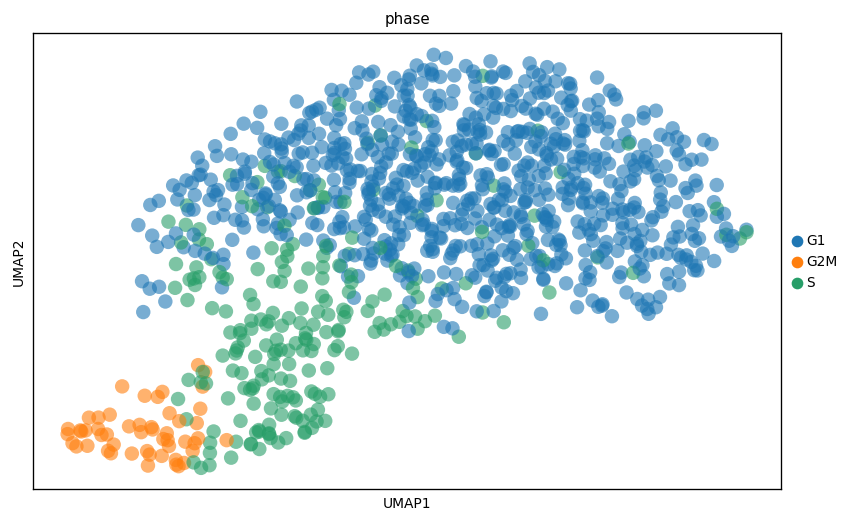

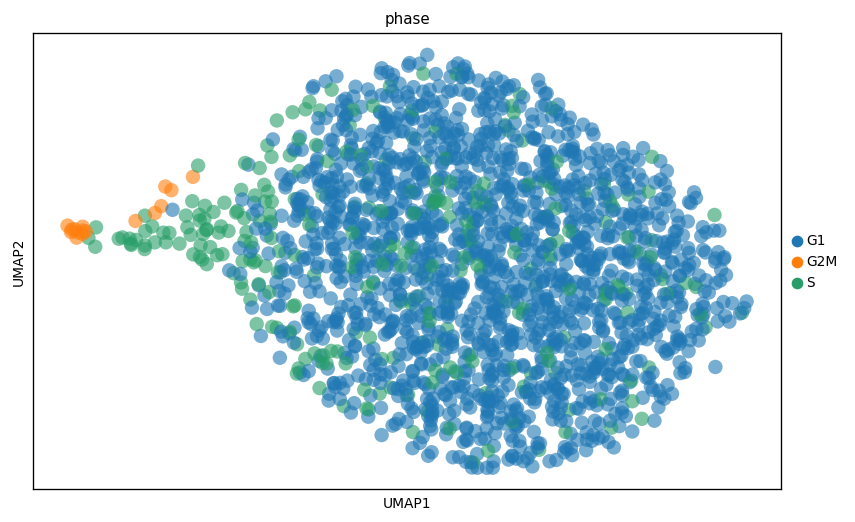

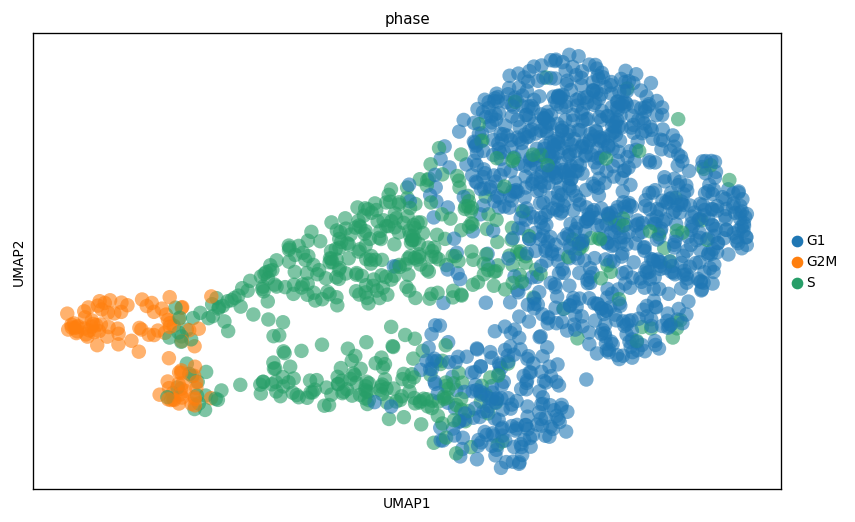

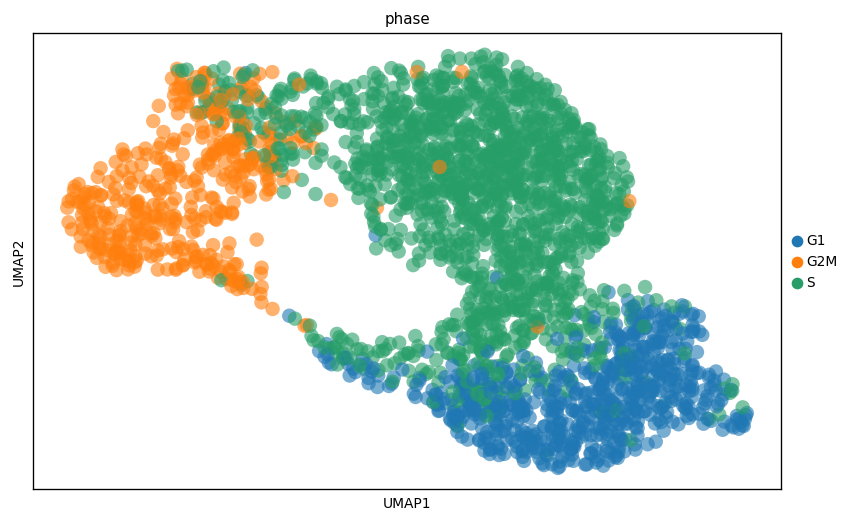

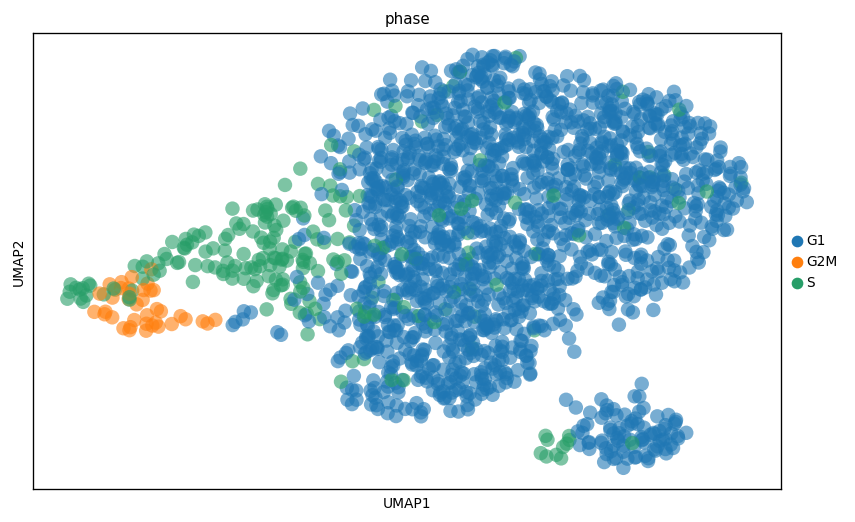

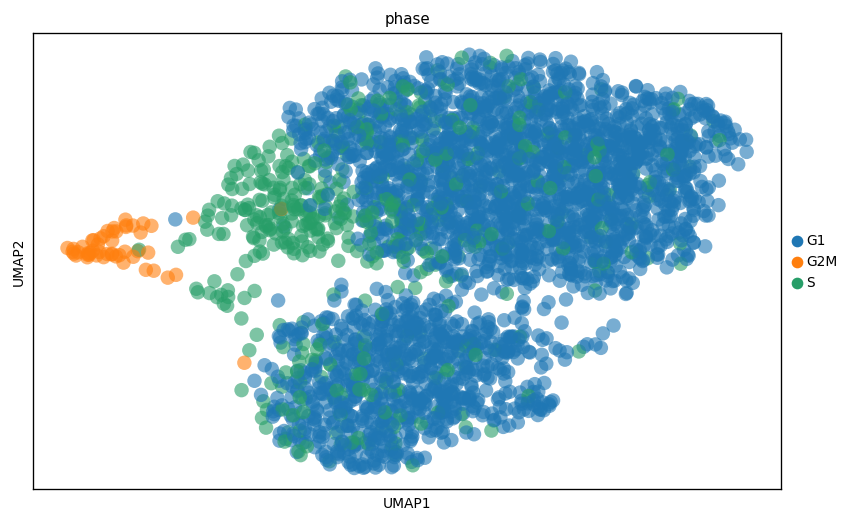

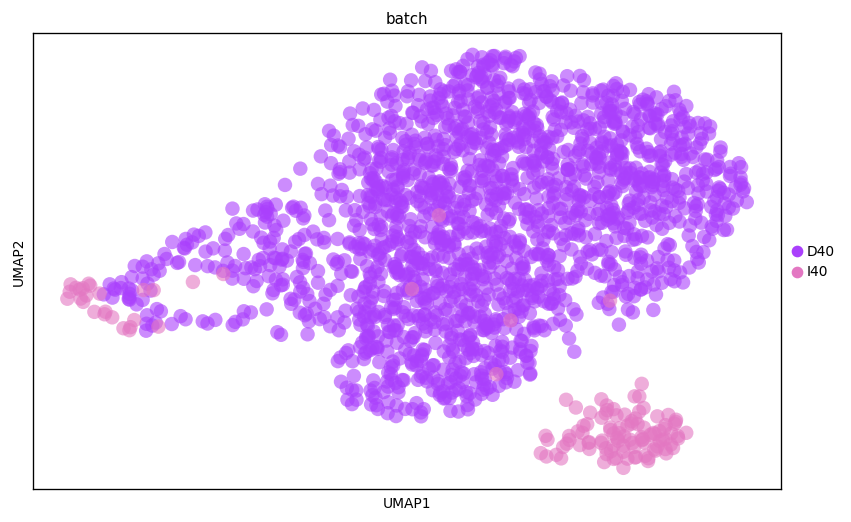

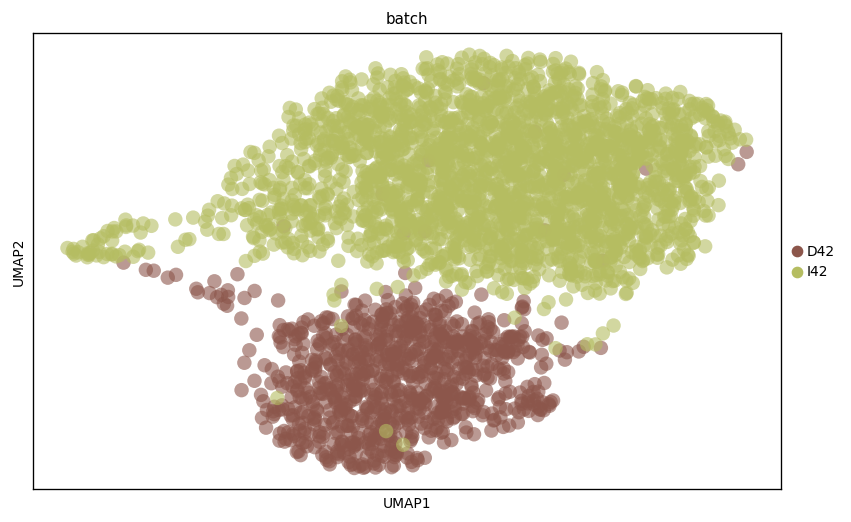

In [28]:
sc.pl.umap(ALL1_model3, color='phase', size=300, alpha=0.6, save='_ALL1_HVG_quartile_filt.pdf')
sc.pl.umap(ALL3_model3, color='phase', size=300, alpha=0.6, save='_ALL3_HVG_quartile_filt.pdf')
sc.pl.umap(ALL8_model3, color='phase', size=300, alpha=0.6, save='_ALL8_HVG_quartile_filt.pdf')
sc.pl.umap(ALL9_model3, color='phase', size=300, alpha=0.6, save='_ALL9_HVG_quartile_filt.pdf')
sc.pl.umap(ALL10_model3, color='phase', size=300, alpha=0.6, save='_ALL10_HVG_quartile_filt.pdf')
sc.pl.umap(ALL12_model3, color='phase', size=300, alpha=0.6, save='_ALL12_HVG_quartile_filt.pdf')
sc.pl.umap(ALL10_model3, color='batch', size=300, alpha=0.6, save='_ALL10_HVG_quartile_filt2.pdf')
sc.pl.umap(ALL12_model3, color='batch', size=300, alpha=0.6, save='_ALL12_HVG_quartile_filt2.pdf')

In [30]:
cmap_batch = matplotlib.cm.get_cmap('Set1')

In [40]:
ALL10.uns['batch_colors'] = [cmap_batch(4), cmap_batch(6)]
ALL12.uns['batch_colors'] = [cmap_batch(5), cmap_batch(7)]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


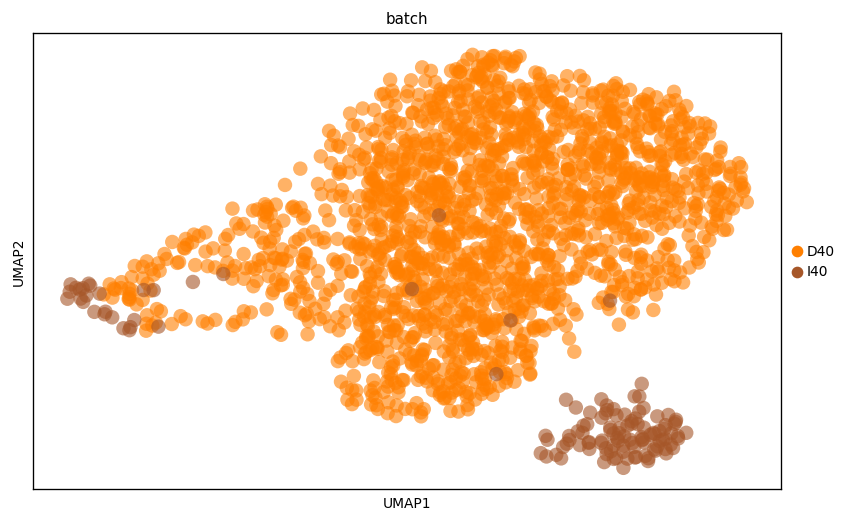

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


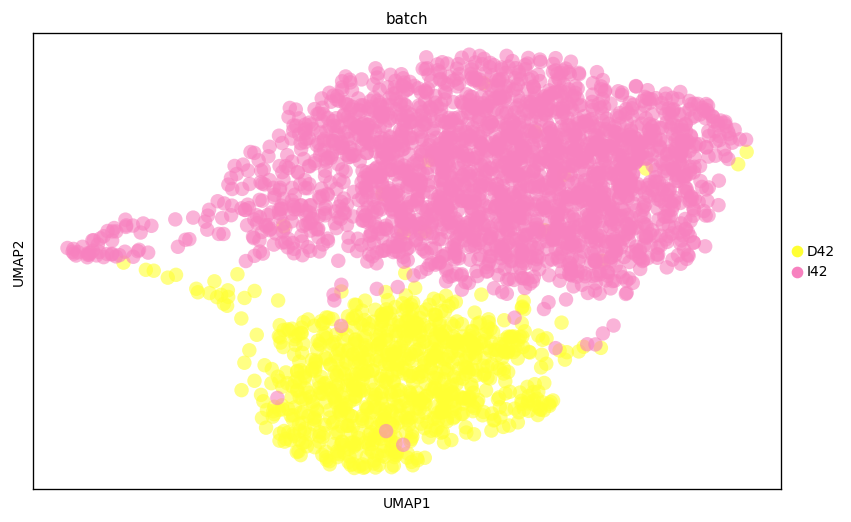

In [41]:
sc.pl.umap(ALL10_model3, color='batch', size=300, alpha=0.6, save='_ALL10_HVG_quartile_filt2.pdf')
sc.pl.umap(ALL12_model3, color='batch', size=300, alpha=0.6, save='_ALL12_HVG_quartile_filt2.pdf')